11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)


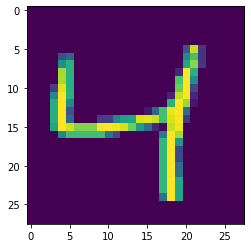

In [ ]:
import keras
import numpy as np
from keras.datasets import mnist
#download mnist data and split into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape,y_train.shape)

import matplotlib.pyplot as plt
#plot the first image in the dataset
plt.imshow(X_train[2])
np.random.seed(10)

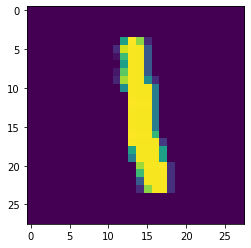

In [ ]:
#reshape data to fit model
X_train = X_train.reshape(60000,1,28,28)
X_test = X_test.reshape(10000,1,28,28)

from keras.utils import to_categorical
#one-hot encode target column
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)
plt.imshow(X_train[6,0])

In [ ]:
def conv_forward(x, w, b, conv_param):


    N, C, H, W = np.shape(x)
    F, _, HH, WW = w.shape
    stride = conv_param['stride']
    pad = conv_param['pad']

    H_next = int(1 + (H + 2 * pad - HH) / stride)
    W_next = int(1 + (W + 2 * pad - WW) / stride)
    out_shape = (N, F, H_next, W_next)
    out = np.zeros(out_shape)
    
    npad = ((0, 0), (0, 0), (1, 1), (1, 1))  # pad around x's 3rd and 4th dimensions
    padded_x = np.pad(x, pad_width=npad, mode='constant', constant_values=0)

    for n in range(N):
      for f in range(F):
        for h_stride in range(H_next):
          for v_stride in range(W_next):
           
            region_of_x = padded_x[n, 
                                   :, # all of the filters/channels
                                   h_stride*stride : h_stride*stride+HH,
                                   v_stride*stride : v_stride*stride+WW]
            out[n, f, h_stride, v_stride] = np.sum(region_of_x * w[f]) + b[f]
    cache = (x, w, b, conv_param)
    return out, cache        

In [ ]:
def conv_backward (dout,cache):
  x, w, b, conv_param = cache
  N, C, H, W = np.shape(x)
  F, _, HH, WW = w.shape
  stride = conv_param['stride']
  pad = conv_param['pad']
  _, _, H_next, W_next = dout.shape

  npad = ((0, 0), (0, 0), (1, 1), (1, 1))  # pad around x's 3rd and 4th dimensions
  padded_x = np.pad(x, pad_width=npad, mode='constant', constant_values=0)

  db = np.sum(dout, axis=(0,2,3))
  dw = np.zeros(w.shape)
  dpadded_x = np.zeros(padded_x.shape)

  for n in range(N):
    for f in range(F):
      for h_stride in range(H_next):
        for v_stride in range(W_next):
          dw[f] += padded_x[n, :, 
                             h_stride*stride : h_stride*stride+HH, 
                             v_stride*stride : v_stride*stride+WW] * dout[n, f, h_stride, v_stride]
          dpadded_x[n, :, h_stride*stride : h_stride*stride+HH, v_stride*stride : v_stride*stride+WW] += w[f] * dout[n, f, h_stride, v_stride]
  dx = dpadded_x[:,:,1:-1,1:-1]      
    
  return dx, dw, db


In [ ]:
def relu_forward(x):
  out = np.maximum(0, x)
  cache = x
  return out, cache


def relu_backward(dout, cache):
  x = cache
  dx = dout
  dx[x <= 0] = 0
  return dx


In [ ]:
def affine_forward(x, w, b):
  N = np.shape(x)[0]
  M = np.product(np.shape(x)[1:])
  xReshaped = x.reshape(N, M)
  out = np.dot(xReshaped, w) + b

  cache = (x, w, b)
  return out, cache

def affine_backward(dout, cache):

  x, w, b = cache

  N = np.shape(x)[0]
  M = np.product(np.shape(x)[1:])
  xReshaped = x.reshape(N, M)
  dw = np.dot(xReshaped.T, dout)
  dx = np.dot(dout, w.T)                # N,M * M,D
  dx = dx.reshape(N, *np.shape(x)[1:])  # reshape to N, d1, d2, d3
  db = np.sum(dout, axis=0)
  return dx, dw, db

In [ ]:
def softmax_loss(x, y):
  probs = np.exp(x - np.max(x, axis=1, keepdims=True))
  probs /= np.sum(probs, axis=1, keepdims=True)
  N = x.shape[0]
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N
  dx = probs.copy()
  dx[np.arange(N), y] -= 1
  dx /= N
  return loss,dx

In [ ]:
def loss_func(W1,W2,W3,b1,b2,b3,x,y,conv_param):
  #FWD pass
  
  out1,cache1=conv_forward(x, W1, b1, conv_param) #CONV layer1
  
  out2,cache2= relu_forward(out1)
  #print(x.shape,W1.shape,b1.shape,out1.shape,out2.shape)
  out3,cache3=conv_forward(out2, W2, b2, conv_param) #CONV layer2
  out4,cache4=  relu_forward(out3)
  #print(W2.shape,b2.shape,out3.shape,out4.shape)
  scores,cache5=affine_forward(out4, W3, b3)
  #print(W3.shape,b3.shape,scores.shape)

  loss, dscores = softmax_loss(scores, y)
  accuracy=np.sum(np.argmax(scores,axis=1)==y)

  #print(loss,dscores.shape)
  dout4, dW3, db3 = affine_backward(dscores, cache5)
 # print(np.unique(cache5[0]))
  #print(np.unique(dW3))
  dout3=relu_backward(dout4, cache4)
  dout2, dW2, db2=conv_backward (dout3,cache3)
  dout1=relu_backward(dout2, cache2)
  _, dW1, db1=conv_backward (dout1,cache1)
 
  #Updating parameters
  grad={'dW1':dW1,'db1':db1,'dW2':dW2,'db2':db2,'dW3':dW3,'db3':db3}
  return loss,scores,grad,accuracy

In [ ]:
def fwd_pass(W1,W2,W3,b1,b2,b3,x,y,conv_param):
  #FWD pass
  
  out1,_=conv_forward(x, W1, b1, conv_param) #CONV layer1
  
  out2,_= relu_forward(out1)
  #print(x.shape,W1.shape,b1.shape,out1.shape,out2.shape)
  out3,_=conv_forward(out2, W2, b2, conv_param) #CONV layer2
  out4,_=  relu_forward(out3)
  #print(W2.shape,b2.shape,out3.shape,out4.shape)
  scores,_=affine_forward(out4, W3, b3)
  #print(W3.shape,b3.shape,scores.shape)

  loss, dscores = softmax_loss(scores, y)
  accuracy=np.sum(np.argmax(scores,axis=1)==y)

  return loss,scores,accuracy


In [ ]:
class AdamOptim():
    def __init__(self,num_filters ,num_filters1, C,filter_size, num_classes, hidden_dim,eta=1e-2, beta1=0.9, beta2=0.999, epsilon=1e-8):
        size1=(num_filters, C, filter_size, filter_size)
        size2=(num_filters1, num_filters, filter_size, filter_size)
        size3=(hidden_dim, num_classes)

        self.m_dw1, self.v_dw1 = np.zeros(size1), np.zeros(size1)
        self.m_db1, self.v_db1 = np.zeros(num_filters), np.zeros(num_filters)

        self.m_dw2, self.v_dw2 = np.zeros(size2), np.zeros(size2)
        self.m_db2, self.v_db2 = np.zeros(num_filters1), np.zeros(num_filters1)

        self.m_dw3, self.v_dw3 = np.zeros(size3), np.zeros(size3)
        self.m_db3, self.v_db3 = np.zeros(num_classes), np.zeros(num_classes)


        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.eta = eta
    def update(self,t,w1,w2,w3,b1,b2,b3,dw1,dw2,dw3,db1,db2,db3):
        ## dw, db are from current minibatch
        ## momentum beta 1
        # *** weights *** #
        self.m_dw1 = self.beta1*self.m_dw1 + (1-self.beta1)*dw1
        self.m_dw2 = self.beta1*self.m_dw2 + (1-self.beta1)*dw2
        self.m_dw3 = self.beta1*self.m_dw3 + (1-self.beta1)*dw3
        # *** biases *** #
        self.m_db1 = self.beta1*self.m_db1 + (1-self.beta1)*db1
        self.m_db2 = self.beta1*self.m_db2 + (1-self.beta1)*db2
        self.m_db3 = self.beta1*self.m_db3 + (1-self.beta1)*db3

        ## rms beta 2
        # *** weights *** #
        self.v_dw1 = self.beta2*self.v_dw1 + (1-self.beta2)*(dw1**2)
        self.v_dw2 = self.beta2*self.v_dw2 + (1-self.beta2)*(dw2**2)
        self.v_dw3 = self.beta2*self.v_dw3 + (1-self.beta2)*(dw3**2)
        # *** biases *** #
        self.v_db1 = self.beta2*self.v_db1 + (1-self.beta2)*(db1**2)
        self.v_db2 = self.beta2*self.v_db2 + (1-self.beta2)*(db2**2)
        self.v_db3 = self.beta2*self.v_db3 + (1-self.beta2)*(db3**2)

        ## bias correction
        m_dw1_corr = self.m_dw1/(1-self.beta1**t)
        m_dw2_corr = self.m_dw2/(1-self.beta1**t)
        m_dw3_corr = self.m_dw3/(1-self.beta1**t)

        m_db1_corr = self.m_db1/(1-self.beta1**t)
        m_db2_corr = self.m_db2/(1-self.beta1**t)
        m_db3_corr = self.m_db3/(1-self.beta1**t)

        v_dw1_corr = self.v_dw1/(1-self.beta2**t)
        v_dw2_corr = self.v_dw2/(1-self.beta2**t)
        v_dw3_corr = self.v_dw3/(1-self.beta2**t)

        v_db1_corr = self.v_db1/(1-self.beta2**t)
        v_db2_corr = self.v_db2/(1-self.beta2**t)
        v_db3_corr = self.v_db3/(1-self.beta2**t)

        ## update weights and biases
        w1 = w1 - self.eta*(m_dw1_corr/(np.sqrt(v_dw1_corr)+self.epsilon))
        w2 = w2 - self.eta*(m_dw2_corr/(np.sqrt(v_dw2_corr)+self.epsilon))
        w3 = w3 - self.eta*(m_dw3_corr/(np.sqrt(v_dw3_corr)+self.epsilon))
        b1 = b1 - self.eta*(m_db1_corr/(np.sqrt(v_db1_corr)+self.epsilon))
        b2 = b2 - self.eta*(m_db2_corr/(np.sqrt(v_db2_corr)+self.epsilon))
        b3 = b3 - self.eta*(m_db3_corr/(np.sqrt(v_db3_corr)+self.epsilon))
        return w1,w2,w3, b1,b2,b3

In [ ]:

num_filters ,num_filters1, C,filter_size, num_classes=8,8,1,3 ,10
hidden_dim=num_filters1 * X_train.shape[2] * X_train.shape[3]
conv_param = {'stride': 1, 'pad': (filter_size - 1) // 2}
weight_scale=1e-2
#initializing parameters
W1 = np.random.normal(scale=weight_scale,size=(num_filters, C, filter_size, filter_size))
b1 = np.zeros(num_filters)
W2 = np.random.normal(scale=weight_scale,size=(num_filters1, num_filters, filter_size, filter_size))
b2 = np.zeros(num_filters1)
W3 = np.random.normal(scale=weight_scale,size=(hidden_dim, num_classes))
b3 = np.zeros(num_classes)



In [ ]:

batch_size,epoch,t=16,10,3
idx=np.arange(X_train.shape[0])
np.random.shuffle(idx)
N=int(X_train.shape[0]/batch_size)

adam = AdamOptim(num_filters ,num_filters1, C,filter_size, num_classes, hidden_dim)
l=[]
a=[]
for i in range(epoch):
  print('Epoch no.',i+1)
  for j in range(N):
    loss,scores,grad,accuracy=loss_func(W1,W2,W3,b1,b2,b3,
                               X_train[idx[j*batch_size:(j+1)*batch_size]],
                               y_train[idx[j*batch_size:(j+1)*batch_size]],
                               conv_param)

    W1,W2,W3,b1,b2,b3= adam.update(t,W1,W2,W3,b1,b2,b3,grad['dW1'],grad['dW2'],grad['dW3'],grad['db1'],grad['db2'],grad['db3'] )
    l.append(loss)
    a.append(accuracy)
    
    t+=1

    if (j%10==0): 
      print('iteration',j+1,'loss : ',loss ,'Accuracy:',accuracy/batch_size)
    if(j==N-1):
      print('Avg Accuracy for epoch',i+1,' :',sum(a[i*N:i+1*(N-1)])/N)
#out1,cache1=conv_forward(X_train[:100], W1, b1, conv_param)

Epoch no. 1
iteration 1 loss :  2.2924060077856137 Accuracy: 0.1875
iteration 11 loss :  1.9867380628764235 Accuracy: 0.375
iteration 21 loss :  0.8257145216750124 Accuracy: 0.8125
iteration 31 loss :  0.8049887939485889 Accuracy: 0.75
iteration 41 loss :  0.45349341174421764 Accuracy: 0.75
iteration 51 loss :  1.3232535983710991 Accuracy: 0.5
iteration 61 loss :  0.4548942283743539 Accuracy: 0.875
iteration 71 loss :  0.5411731108713921 Accuracy: 0.875
iteration 81 loss :  0.49066545613327595 Accuracy: 0.75
iteration 91 loss :  0.5499907341558805 Accuracy: 0.875
iteration 101 loss :  0.7045329780525675 Accuracy: 0.75
iteration 111 loss :  0.6535912429429207 Accuracy: 0.8125
iteration 121 loss :  0.9303961742658182 Accuracy: 0.75
iteration 131 loss :  0.859767383101913 Accuracy: 0.6875
iteration 141 loss :  0.22411893286615409 Accuracy: 0.875
iteration 151 loss :  0.6924468543899909 Accuracy: 0.8125
iteration 161 loss :  0.2590963038077118 Accuracy: 0.9375
iteration 171 loss :  0.67438

In [ ]:
#print(out1.max())